In [ ]:
"""
File: Maia_DataAnalysis.ipynb
Author: Pedro Maia
Date: 10/31/25
Last Modified: 11/21/2025
Description: Data Analysis Project
"""

Data successfully loaded and cleaned. Total usable daily records: 3917
----------------------------------------------------------------------
Daily Correlation: Solar Energy (Cloud Proxy) vs. Temp Range
Pearson Correlation Coefficient (r): 0.0595
P-value: 0.000195
----------------------------------------------------------------------


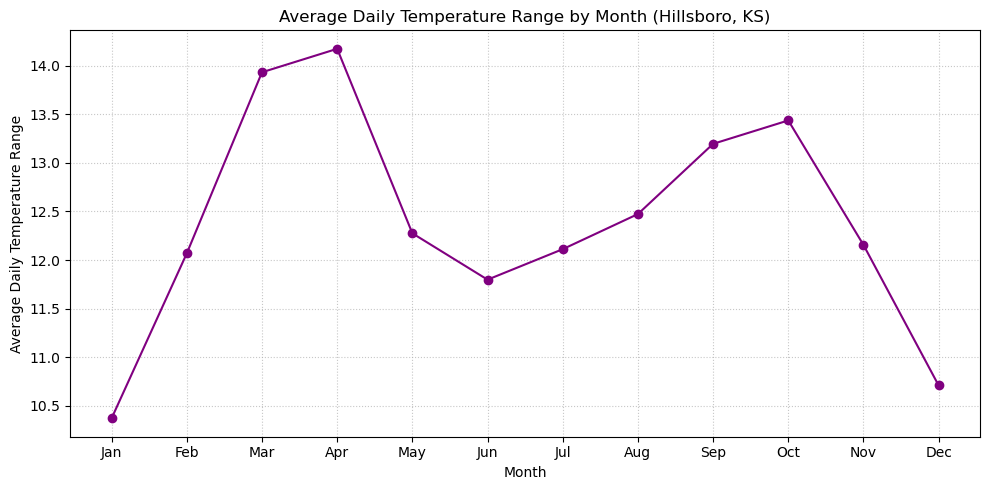

In [19]:

# PROJECT OBJECTIVE  
# My project uses Python data science libraries to analyze historical daily weather data.
# The goal is two-fold:
# 1. TIME SERIES: Determine the average temperature range (Max Temp - Min Temp) across the months of the year.
# 2. CORRELATION: Test the statistical relationship between clear skies (measured by solar energy) and the daily temperature swing.

import pandas as pd     
import numpy as np      
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr 
import io               

# DATA CONFIGURATION AND LOADING PARAMETERS

# I define the expected file name for reference.
FILE_NAME = 'POWER_Point_Daily_20150101_20251001_038d35N_097d21W_LST.csv'
# I define the value used in the raw dataset to represent missing data.
MISSING_VALUE = -999.0
# I define the exact column names needed for the analysis.
COLUMNS = ['YEAR', 'DOY', 'T2M_MAX', 'T2M_MIN', 'CLRSKY_SFC_SW_DWN']


# I use a try-except block for robust data loading, as raw files often have headers/metadata.
try:
    # I use pd.read_csv to load the data from the CSV file.
    df = pd.read_csv(
        FILE_NAME, 
        skiprows=10,  # I skip the first 10 rows of header information to start at the data.
        sep=',',      # I specify the comma separator.
        header=None,  # I indicate that the header is not on the first line I read.
        names=COLUMNS,# I manually assign the predefined column names.
        skipfooter=10,# I skip the last 10 lines of file metadata/notes.
        engine='python' # I use the slower but more robust 'python' engine for handling skipping.
    )
    
except Exception as e:
    # If loading fails due to a parsing error, I print the error and stop execution.
    print(f"A final parsing error occurred: {e}. Please ensure no other rows were added/removed from the file.")
    raise 

# DATA CLEANING AND CORE CALCULATIONS

# I convert the maximum temperature column to numeric, replacing missing value codes with np.nan.
df['T2M_MAX'] = pd.to_numeric(df['T2M_MAX'].replace(MISSING_VALUE, np.nan), errors='coerce')
# I convert the minimum temperature column to numeric, replacing missing value codes with np.nan.
df['T2M_MIN'] = pd.to_numeric(df['T2M_MIN'].replace(MISSING_VALUE, np.nan), errors='coerce')
# I convert the solar energy column (my cloud proxy) to numeric, handling missing values.
df['CLRSKY_SFC_SW_DWN'] = pd.to_numeric(df['CLRSKY_SFC_SW_DWN'].replace(MISSING_VALUE, np.nan), errors='coerce')

# I ensure the year column is a string for correct date combining later.
df['YEAR'] = df['YEAR'].astype(str)

# I calculate the Daily Temperature Range (Max - Min).
# This is a core NumPy/Pandas vectorized operation, which is highly efficient.
df['Temp_Range'] = df['T2M_MAX'] - df['T2M_MIN']

# I remove any rows that still contain missing data (np.nan) in the crucial columns.
df.dropna(subset=['Temp_Range', 'CLRSKY_SFC_SW_DWN'], inplace=True)
# I reset the DataFrame index after cleaning the data.
df.reset_index(drop=True, inplace=True)

# 2. Daily Correlation Analysis
# I calculate the Pearson 'r' and the p-value. This tests my statistical hypothesis:
# is solar energy (cloud proxy) related to the temperature range?
r, p_value = pearsonr(df['CLRSKY_SFC_SW_DWN'], df['Temp_Range'])

print(f"Data successfully loaded and cleaned. Total usable daily records: {len(df)}")
print("-" * 70)
print("Daily Correlation: Solar Energy (Cloud Proxy) vs. Temp Range")
print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"P-value: {p_value:.6f}")
print("-" * 70)

# MONTHLY TREND ANALYSIS

# I convert the year and doy (Day of Year) into a proper Pandas datetime object.
df['Date'] = pd.to_datetime(df['YEAR'] + df['DOY'].astype(str), format='%Y%j')

# I extract the numerical month (1-12) from the Date column for grouping.
df['Month_Num'] = df['Date'].dt.month

# I use Pandas groupby() to aggregate the data by month and calculate the average (mean) range.
# This reveals the typical seasonal climate trend.
df_monthly_avg = df.groupby('Month_Num')['Temp_Range'].mean().reset_index()
df_monthly_avg.columns = ['Month_Num', 'Avg_Temp_Range']

# I map month numbers to names for clear visualization.
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_monthly_avg['Month_Name'] = df_monthly_avg['Month_Num'].map(month_map)

# I create the Matplotlib figure for the plot. 
plt.figure(figsize=(10, 5))

# I plot the Monthly Name (X-axis) against the Average Temperature Range (Y-axis).
plt.plot(df_monthly_avg['Month_Name'], df_monthly_avg['Avg_Temp_Range'], 
         marker='o', linestyle='-', color='purple')

# I set the titles and labels for clear presentation of the results.
plt.title('Average Daily Temperature Range by Month (Hillsboro, KS)')
plt.xlabel('Month')
plt.ylabel('Average Daily Temperature Range')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()